# Interactive multi-compartment OLM cell example

To run this interactive Jupyter Notebook, please click on the rocket icon 🚀 in the top panel. For more information, please see {ref}`how to use this documentation <userdocs:usage:jupyterbooks>`. Please uncomment the line below if you use the Google Colab. (It does not include these packages by default).

In [1]:
#%pip install pyneuroml neuromllite NEURON

In [2]:
#!/usr/bin/env python3
"""
Multi-compartmental OLM cell example

File: olm-example.py

Copyright 2023 NeuroML contributors
Authors: Padraig Gleeson, Ankur Sinha
"""

import neuroml
from neuroml import NeuroMLDocument
from neuroml.utils import component_factory
from pyneuroml import pynml
from pyneuroml.lems import LEMSSimulation
from pyneuroml.plot.PlotMorphology import plot_2D
import numpy as np

The CellBuilder module file can be found in the same folder as the Python script. It is used to define the helper functions that we use in our main file.

## Declaring the NeuroML model
### Create the cell

In this example, we do not create the ion channels. We include ion channels that are already provided in NeuroML files. 

In [3]:
def create_olm_cell():
    """Create the complete cell.

    :returns: cell object
    """
    nml_cell_doc = component_factory("NeuroMLDocument", id="oml_cell")
    cell = nml_cell_doc.add("Cell", id="olm", neuro_lex_id="NLXCELL:091206")  # type neuroml.Cell
    nml_cell_file = cell.id + ".cell.nml"

    cell.summary()
    cell.info(show_contents=True)
    cell.morphology.info(show_contents=True)

    # Add two soma segments to an unbranched segment group
    cell.add_unbranched_segment_group("soma_0")
    diam = 10.0
    soma_0 = cell.add_segment(
        prox=[0.0, 0.0, 0.0, diam],
        dist=[0.0, 10., 0.0, diam],
        name="Seg0_soma_0",
        group_id="soma_0",
        seg_type="soma"
    )

    soma_1 = cell.add_segment(
        prox=None,
        dist=[0.0, 10. + 10., 0.0, diam],
        name="Seg1_soma_0",
        parent=soma_0,
        group_id="soma_0",
        seg_type="soma"
    )

    # Add axon segments
    diam = 1.5
    cell.add_unbranched_segments(
        [
            [0.0, 0.0, 0.0, diam],
            [0.0, -75, 0.0, diam],
            [0.0, -150, 0.0, diam],
        ],
        parent=soma_0,
        fraction_along=0.0,
        group_id="axon_0",
        seg_type="axon"
    )

    # Add 2 dendrite segments, using the branching utility function

    diam = 3.0
    cell.add_unbranched_segments(
        [
            [0.0, 20.0, 0.0, diam],
            [100, 120, 0.0, diam],
            [177, 197, 0.0, diam],
        ],
        parent=soma_1,
        fraction_along=1.0,
        group_id="dend_0",
        seg_type="dendrite"
    )

    cell.add_unbranched_segments(
        [
            [0.0, 20.0, 0.0, diam],
            [-100, 120, 0.0, diam],
            [-177, 197, 0.0, diam],
        ],
        parent=soma_1,
        fraction_along=1.0,
        group_id="dend_1",
        seg_type="dendrite"
    )

    # color groups for morphology plots
    den_seg_group = cell.get_segment_group("dendrite_group")
    den_seg_group.add("Property", tag="color", value="0.8 0 0")

    ax_seg_group = cell.get_segment_group("axon_group")
    ax_seg_group.add("Property", tag="color", value="0 0.8 0")

    soma_seg_group = cell.get_segment_group("soma_group")
    soma_seg_group.add("Property", tag="color", value="0 0 0.8")

    # Other cell properties
    cell.set_init_memb_potential("-67mV")
    cell.set_resistivity("0.15 kohm_cm")
    cell.set_specific_capacitance("1.3 uF_per_cm2")

    # channels
    # leak
    cell.add_channel_density(nml_cell_doc,
                             cd_id="leak_all",
                             cond_density="0.01 mS_per_cm2",
                             ion_channel="leak_chan",
                             ion_chan_def_file="olm-example/leak_chan.channel.nml",
                             erev="-67mV",
                             ion="non_specific")
    # HCNolm_soma
    cell.add_channel_density(nml_cell_doc,
                             cd_id="HCNolm_soma",
                             cond_density="0.5 mS_per_cm2",
                             ion_channel="HCNolm",
                             ion_chan_def_file="olm-example/HCNolm.channel.nml",
                             erev="-32.9mV",
                             ion="h",
                             group_id="soma_group")
    # Kdrfast_soma
    cell.add_channel_density(nml_cell_doc,
                             cd_id="Kdrfast_soma",
                             cond_density="73.37 mS_per_cm2",
                             ion_channel="Kdrfast",
                             ion_chan_def_file="olm-example/Kdrfast.channel.nml",
                             erev="-77mV",
                             ion="k",
                             group_id="soma_group")
    # Kdrfast_dendrite
    cell.add_channel_density(nml_cell_doc,
                             cd_id="Kdrfast_dendrite",
                             cond_density="105.8 mS_per_cm2",
                             ion_channel="Kdrfast",
                             ion_chan_def_file="olm-example/Kdrfast.channel.nml",
                             erev="-77mV",
                             ion="k",
                             group_id="dendrite_group")
    # Kdrfast_axon
    cell.add_channel_density(nml_cell_doc,
                             cd_id="Kdrfast_axon",
                             cond_density="117.392 mS_per_cm2",
                             ion_channel="Kdrfast",
                             ion_chan_def_file="olm-example/Kdrfast.channel.nml",
                             erev="-77mV",
                             ion="k",
                             group_id="axon_group")
    # KvAolm_soma
    cell.add_channel_density(nml_cell_doc,
                             cd_id="KvAolm_soma",
                             cond_density="4.95 mS_per_cm2",
                             ion_channel="KvAolm",
                             ion_chan_def_file="olm-example/KvAolm.channel.nml",
                             erev="-77mV",
                             ion="k",
                             group_id="soma_group")
    # KvAolm_dendrite
    cell.add_channel_density(nml_cell_doc,
                             cd_id="KvAolm_dendrite",
                             cond_density="2.8 mS_per_cm2",
                             ion_channel="KvAolm",
                             ion_chan_def_file="olm-example/KvAolm.channel.nml",
                             erev="-77mV",
                             ion="k",
                             group_id="dendrite_group")
    # Nav_soma
    cell.add_channel_density(nml_cell_doc,
                             cd_id="Nav_soma",
                             cond_density="10.7 mS_per_cm2",
                             ion_channel="Nav",
                             ion_chan_def_file="olm-example/Nav.channel.nml",
                             erev="50mV",
                             ion="na",
                             group_id="soma_group")
    # Nav_dendrite
    cell.add_channel_density(nml_cell_doc,
                             cd_id="Nav_dendrite",
                             cond_density="23.4 mS_per_cm2",
                             ion_channel="Nav",
                             ion_chan_def_file="olm-example/Nav.channel.nml",
                             erev="50mV",
                             ion="na",
                             group_id="dendrite_group")
    # Nav_axon
    cell.add_channel_density(nml_cell_doc,
                             cd_id="Nav_axon",
                             cond_density="17.12 mS_per_cm2",
                             ion_channel="Nav",
                             ion_chan_def_file="olm-example/Nav.channel.nml",
                             erev="50mV",
                             ion="na",
                             group_id="axon_group")

    cell.optimise_segment_groups()
    cell.validate(recursive=True)
    pynml.write_neuroml2_file(nml_cell_doc, nml_cell_file, True, True)
    plot_2D(nml_cell_file, plane2d="xy", nogui=True,
            save_to_file="olm.cell.xy.png")
    return nml_cell_file

### Create the network

In [4]:
def create_olm_network():
    """Create the network

    :returns: name of network nml file
    """
    net_doc = NeuroMLDocument(id="network",
                              notes="OLM cell network")
    net_doc_fn = "olm_example_net.nml"
    net_doc.add("IncludeType", href=create_olm_cell())
    net = net_doc.add("Network", id="single_olm_cell_network", validate=False)
    # Create a population: convenient to create many cells of the same type
    pop = net.add("Population", id="pop0", notes="A population for our cell",
                  component="olm", size=1, type="populationList",
                  validate=False)
    pop.add("Instance", id=0, location=component_factory("Location", x=0., y=0., z=0.))
    # Input
    net_doc.add("PulseGenerator", id="pg_olm", notes="Simple pulse generator", delay="100ms", duration="100ms", amplitude="0.08nA")

    net.add("ExplicitInput", target="pop0[0]", input="pg_olm")

    pynml.write_neuroml2_file(nml2_doc=net_doc, nml2_file_name=net_doc_fn, validate=True)
    return net_doc_fn

## Plot the data we record

In [5]:
def plot_data(sim_id):
    """Plot the sim data.

    Load the data from the file and plot the graph for the membrane potential
    using the pynml generate_plot utility function.

    :sim_id: ID of simulaton

    """
    data_array = np.loadtxt(sim_id + ".dat")
    pynml.generate_plot([data_array[:, 0]], [data_array[:, 1]], "Membrane potential (soma seg 0)", show_plot_already=False, save_figure_to=sim_id + "_seg0_soma0-v.png", xaxis="time (s)", yaxis="membrane potential (V)")
    pynml.generate_plot([data_array[:, 0]], [data_array[:, 2]], "Membrane potential (soma seg 1)", show_plot_already=False, save_figure_to=sim_id + "_seg1_soma0-v.png", xaxis="time (s)", yaxis="membrane potential (V)")
    pynml.generate_plot([data_array[:, 0]], [data_array[:, 3]], "Membrane potential (axon seg 0)", show_plot_already=False, save_figure_to=sim_id + "_seg0_axon0-v.png", xaxis="time (s)", yaxis="membrane potential (V)")
    pynml.generate_plot([data_array[:, 0]], [data_array[:, 4]], "Membrane potential (axon seg 1)", show_plot_already=False, save_figure_to=sim_id + "_seg1_axon0-v.png", xaxis="time (s)", yaxis="membrane potential (V)")

## Create and run the simulaton

In [6]:
def main():
    """Main function

    Include the NeuroML model into a LEMS simulation file, run it, plot some
    data.
    """
    # Simulation bits
    sim_id = "olm_example_sim"
    simulation = LEMSSimulation(sim_id=sim_id, duration=600, dt=0.01, simulation_seed=123)
    # Include the NeuroML model file
    simulation.include_neuroml2_file(create_olm_network())
    # Assign target for the simulation
    simulation.assign_simulation_target("single_olm_cell_network")

    # Recording information from the simulation
    simulation.create_output_file(id="output0", file_name=sim_id + ".dat")
    simulation.add_column_to_output_file("output0", column_id="pop0_0_v", quantity="pop0[0]/v")
    simulation.add_column_to_output_file("output0",
                                         column_id="pop0_0_v_Seg0_soma_0",
                                         quantity="pop0/0/olm/0/v")
    simulation.add_column_to_output_file("output0",
                                         column_id="pop0_0_v_Seg1_soma_0",
                                         quantity="pop0/0/olm/1/v")
    simulation.add_column_to_output_file("output0",
                                         column_id="pop0_0_v_Seg0_axon_0",
                                         quantity="pop0/0/olm/2/v")
    simulation.add_column_to_output_file("output0",
                                         column_id="pop0_0_v_Seg1_axon_0",
                                         quantity="pop0/0/olm/3/v")
    simulation.add_column_to_output_file("output0",
                                         column_id="pop0_0_v_Seg0_dend_0",
                                         quantity="pop0/0/olm/4/v")
    simulation.add_column_to_output_file("output0",
                                         column_id="pop0_0_v_Seg1_dend_0",
                                         quantity="pop0/0/olm/6/v")
    simulation.add_column_to_output_file("output0",
                                         column_id="pop0_0_v_Seg0_dend_1",
                                         quantity="pop0/0/olm/5/v")
    simulation.add_column_to_output_file("output0",
                                         column_id="pop0_0_v_Seg1_dend_1",
                                         quantity="pop0/0/olm/7/v")
    # Save LEMS simulation to file
    sim_file = simulation.save_to_file()

    # Run the simulation using the NEURON simulator
    pynml.run_lems_with_jneuroml_neuron(sim_file, max_memory="2G", nogui=True,
                                        plot=False, skip_run=False)
    # Plot the data
    plot_data(sim_id)

pyNeuroML >>> INFO - Executing: (java -Xmx400M  -jar  "/home/asinha/Documents/02_Code/00_mine/NeuroML/documentation/.venv/lib/python3.10/site-packages/pyneuroml/lib/jNeuroML-0.12.0-jar-with-dependencies.jar" -validate "olm.cell.nml" ) in directory: .


*******************************************************
* Cell: olm
* Notes: None
* Segments: 0
* SegmentGroups: 4
*******************************************************
Cell -- Cell with  **segment** s specified in a  **morphology**  element along with details on its  **biophysicalProperties** . NOTE: this can only be correctly simulated using jLEMS when there is a single segment in the cell, and **v**  of this cell represents the membrane potential in that isopotential segment.

Please see the NeuroML standard schema documentation at https://docs.neuroml.org/Userdocs/NeuroMLv2.html for more information.

Valid members for Cell are:
* morphology_attr (class: NmlId, Optional)
* biophysical_properties_attr (class: NmlId, Optional)
* morphology (class: Morphology, Optional)
	* Contents ('ids'/<objects>): 'morphology'

* neuro_lex_id (class: NeuroLexId, Optional)
	* Contents ('ids'/<objects>): NLXCELL:091206

* biophysical_properties (class: BiophysicalProperties, Optional)
	* Contents (

pyNeuroML >>> INFO - Command completed. Output: 
  jNeuroML >>   jNeuroML v0.12.0
  jNeuroML >>  Validating: /home/asinha/Documents/02_Code/00_mine/NeuroML/documentation/source/Userdocs/NML2_examples/olm.cell.nml
  jNeuroML >>  Valid against schema and all tests
  jNeuroML >>  No warnings
  jNeuroML >>  
  jNeuroML >>  Validated 1 files: All valid and no warnings
  jNeuroML >>  
  jNeuroML >>  
pyNeuroML >>> INFO - Loading NeuroML2 file: olm.cell.nml
pyNeuroML >>> INFO - Including included files (included already: [])
pyNeuroML >>> INFO - Loading NeuroML2 file: /home/asinha/Documents/02_Code/00_mine/NeuroML/documentation/source/Userdocs/NML2_examples/olm-example/leak_chan.channel.nml
pyNeuroML >>> INFO - Including included files (included already: [])
pyNeuroML >>> INFO - Loading NeuroML2 file: /home/asinha/Documents/02_Code/00_mine/NeuroML/documentation/source/Userdocs/NML2_examples/olm-example/HCNolm.channel.nml
pyNeuroML >>> INFO - Including included files (included already: ['/home

Saved image on plane xy to /home/asinha/Documents/02_Code/00_mine/NeuroML/documentation/source/Userdocs/NML2_examples/olm.cell.xy.png of plot: 2D plot of olm from olm.cell.nml


pyNeuroML >>> INFO - Command completed. Output: 
  jNeuroML >>   jNeuroML v0.12.0
  jNeuroML >>  Validating: /home/asinha/Documents/02_Code/00_mine/NeuroML/documentation/source/Userdocs/NML2_examples/olm_example_net.nml
  jNeuroML >>  Valid against schema and all tests
  jNeuroML >>  No warnings
  jNeuroML >>  
  jNeuroML >>  Validated 1 files: All valid and no warnings
  jNeuroML >>  
  jNeuroML >>  
pyNeuroML >>> INFO - Loading NeuroML2 file: /home/asinha/Documents/02_Code/00_mine/NeuroML/documentation/source/Userdocs/NML2_examples/olm_example_net.nml
pyNeuroML >>> INFO - Loading NeuroML2 file: /home/asinha/Documents/02_Code/00_mine/NeuroML/documentation/source/Userdocs/NML2_examples/olm.cell.nml
pyNeuroML >>> INFO - Loading NeuroML2 file: /home/asinha/Documents/02_Code/00_mine/NeuroML/documentation/source/Userdocs/NML2_examples/olm-example/leak_chan.channel.nml
pyNeuroML >>> INFO - Loading NeuroML2 file: /home/asinha/Documents/02_Code/00_mine/NeuroML/documentation/source/Userdocs/NM

pyNeuroML >>> INFO - Saved image to olm_example_sim_seg0_soma0-v.png of plot: Membrane potential (soma seg 0)
pyNeuroML >>> INFO - Generating plot: Membrane potential (soma seg 1)
pyNeuroML >>> INFO - Saving image to /home/asinha/Documents/02_Code/00_mine/NeuroML/documentation/source/Userdocs/NML2_examples/olm_example_sim_seg1_soma0-v.png of plot: Membrane potential (soma seg 1)
pyNeuroML >>> INFO - Saved image to olm_example_sim_seg1_soma0-v.png of plot: Membrane potential (soma seg 1)
pyNeuroML >>> INFO - Generating plot: Membrane potential (axon seg 0)
pyNeuroML >>> INFO - Saving image to /home/asinha/Documents/02_Code/00_mine/NeuroML/documentation/source/Userdocs/NML2_examples/olm_example_sim_seg0_axon0-v.png of plot: Membrane potential (axon seg 0)
pyNeuroML >>> INFO - Saved image to olm_example_sim_seg0_axon0-v.png of plot: Membrane potential (axon seg 0)
pyNeuroML >>> INFO - Generating plot: Membrane potential (axon seg 1)
pyNeuroML >>> INFO - Saving image to /home/asinha/Docume

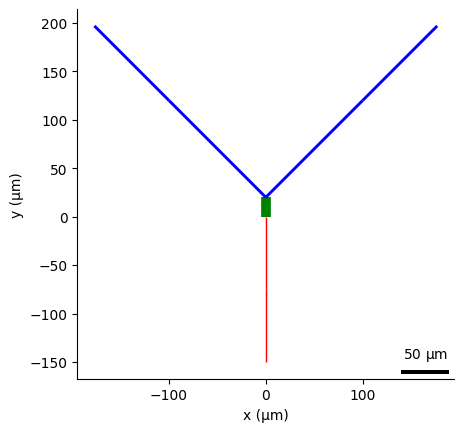

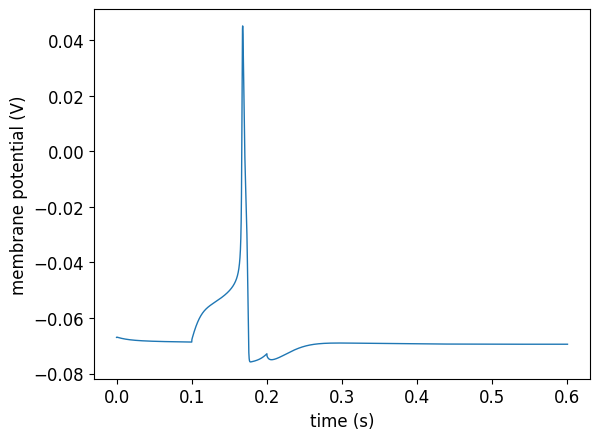

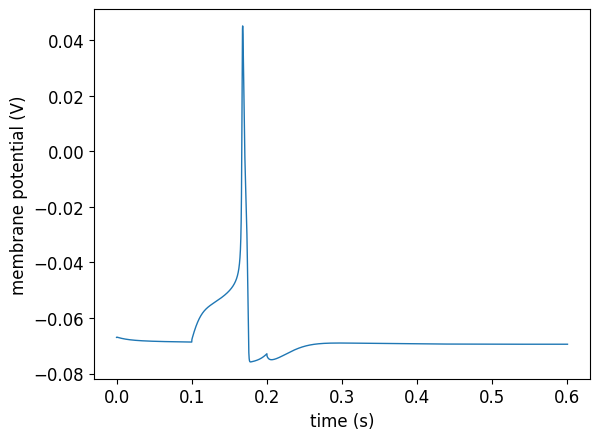

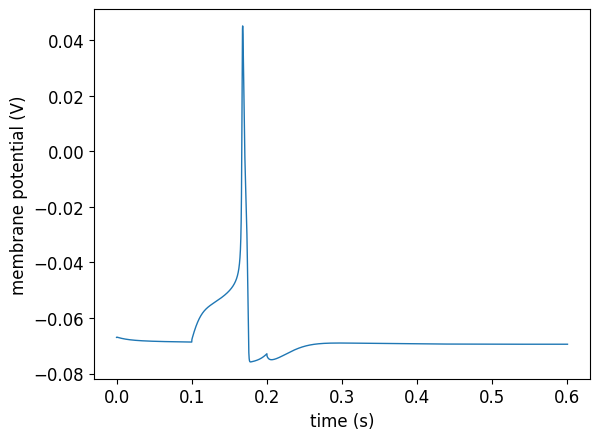

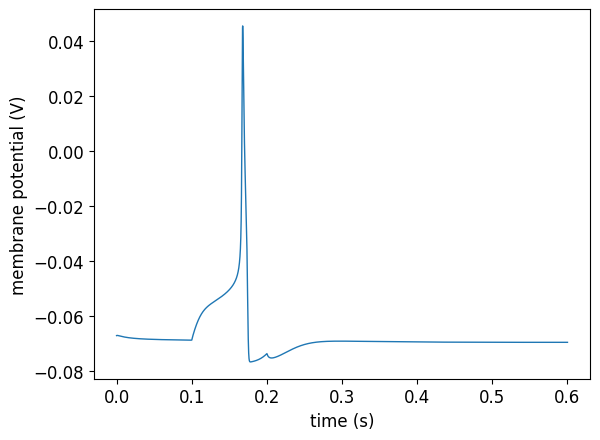

In [7]:
if __name__ == "__main__":
    main()